In [1]:
!nvidia-smi

Wed May 17 23:20:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:00:0D.0 Off |                    0 |
| N/A   48C    P0    73W / 300W |    975MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:00:0E.0 Off |                    0 |
| N/A   

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import math
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
import os 
import glob
import shutil
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

2023-05-18 02:21:29.111473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 02:21:29.555770: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 02:21:30.916414: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-18 02:21:30.916523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
DIR = "../xray/CLAHE_dataset_3_altern/DATASET"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 21852 files belonging to 5 classes.
Using 19667 files for training.


2023-05-18 02:21:34.466494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 02:21:34.469611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 02:21:34.681563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 02:21:34.684639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 02:21:34.688459: I tensorflow/compiler/xla/stream_executo

Found 21852 files belonging to 5 classes.
Using 2185 files for validation.
['Bacterial Pneumonia', 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia']


In [4]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
xception_weights = '../xray/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = Xception(input_shape= (256,256,3), weights=xception_weights, include_top=False)

for layer in base_model.layers:
    layer.trainable = True
# our layers - you can add more if you want
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x) 
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
     
early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 10 ,
                               restore_best_weights=True)
    #model_checkpoint
mc = ModelCheckpoint('xception_model_3_(1)_xx_xx.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
epochs = 40
#stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, 
                  validation_data = test_dataset, 
                  epochs = epochs, 
                  callbacks = [stepDecay,mc])

Epoch 1/40


2023-05-18 02:24:04.636509: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-18 02:24:04.649320: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


615/615 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.8409
Epoch 1: val_loss improved from inf to 0.48026, saving model to xception_model_3_(1)_xx_xx.h5
615/615 [==============================] - 90s 132ms/step - loss: 0.4118 - accuracy: 0.8409 - val_loss: 0.4803 - val_accuracy: 0.7922 - lr: 0.1000
Epoch 2/40
615/615 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.8907
Epoch 2: val_loss improved from 0.48026 to 0.33348, saving model to xception_model_3_(1)_xx_xx.h5
615/615 [==============================] - 83s 133ms/step - loss: 0.2748 - accuracy: 0.8907 - val_loss: 0.3335 - val_accuracy: 0.8659 - lr: 0.1000
Epoch 3/40
615/615 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9034
Epoch 3: val_loss did not improve from 0.33348
615/615 [==============================] - 82s 132ms/step - loss: 0.2391 - accuracy: 0.9034 - val_loss: 0.3815 - val_accuracy: 0.8581 - lr: 0.1000
Epoch 4/40
615/615 [=======================

Epoch 27/40
615/615 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9680
Epoch 27: val_loss did not improve from 0.26709
615/615 [==============================] - 82s 132ms/step - loss: 0.0813 - accuracy: 0.9680 - val_loss: 0.2686 - val_accuracy: 0.9053 - lr: 1.0000e-05
Epoch 28/40
615/615 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9688
Epoch 28: val_loss did not improve from 0.26709
615/615 [==============================] - 82s 132ms/step - loss: 0.0853 - accuracy: 0.9688 - val_loss: 0.2688 - val_accuracy: 0.9053 - lr: 1.0000e-05
Epoch 29/40
615/615 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9709
Epoch 29: val_loss did not improve from 0.26709
615/615 [==============================] - 82s 132ms/step - loss: 0.0811 - accuracy: 0.9709 - val_loss: 0.2676 - val_accuracy: 0.9057 - lr: 1.0000e-05
Epoch 30/40
615/615 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9691
Epoch 30: val_l

In [11]:
model.save('xception_model_3_(2)_96_90.h5')

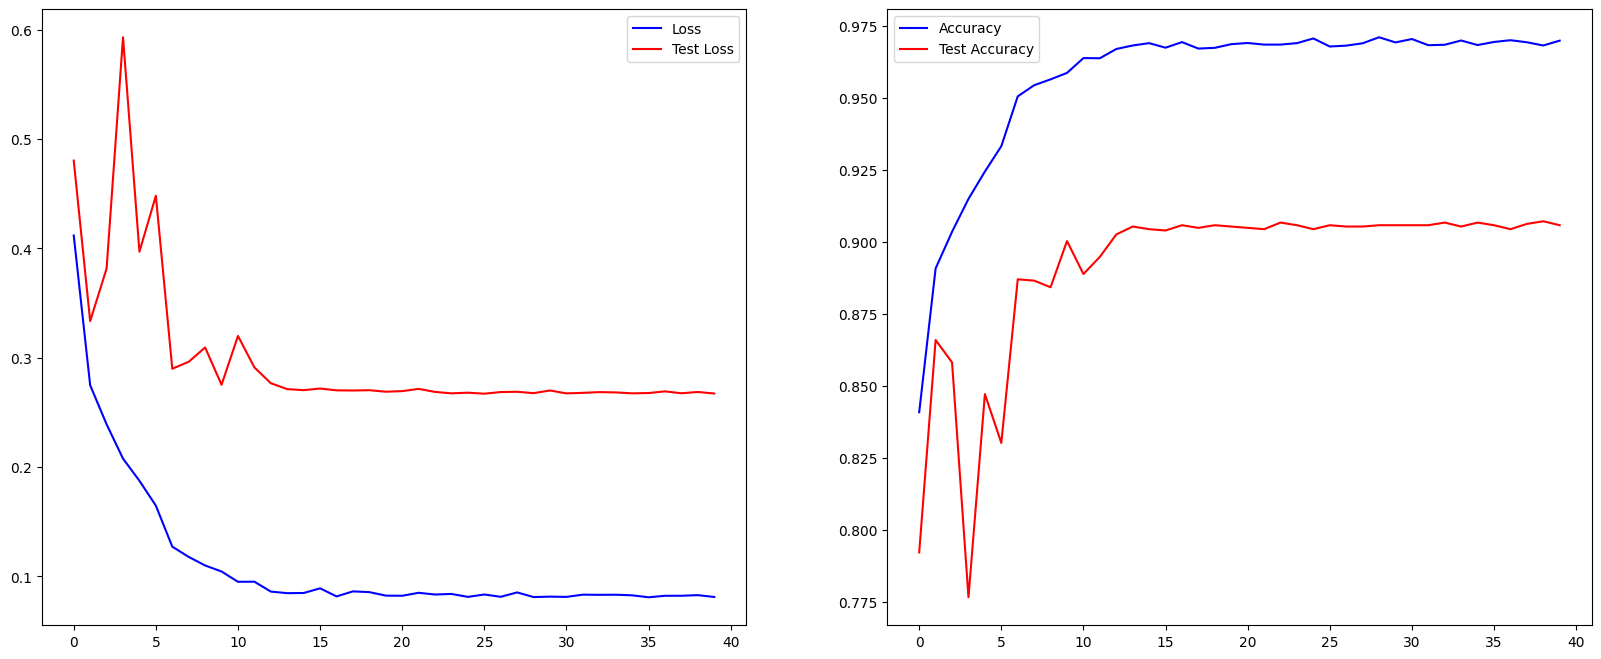

In [10]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()